# Libraries

In [288]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data (2 features, 3 classifications)

In [289]:
df = pd.DataFrame(columns=['x1', 'x2'])
df['x1'] = [0.04,    1,  0.5, 0.12, 0.08, 0.02, 1.2, 0.7,  0.8]
df['x2'] = [0.42, 0.54, 0.65, 0.29, 0.38,  0.5, 0.5, 0.6, 0.55]
df['label'] = [0,1,2,0,0,0,1,2,2]
df

,x1,x2,label
0,0.04,0.42,0
1,1.00,0.54,1
2,0.50,0.65,2
3,0.12,0.29,0
4,0.08,0.38,0
5,0.02,0.50,0
6,1.20,0.50,1
7,0.70,0.60,2
8,0.80,0.55,2


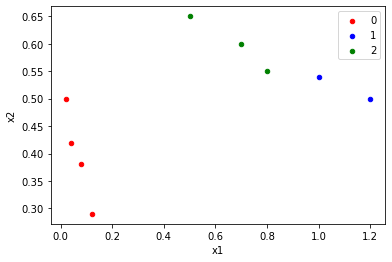

In [290]:
# visualize
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x1', y='x2', label=key, color=colors[key])
pyplot.show()

## one_hot_encode for categorial data (labels in classification problem)

In [291]:
### Categorical data to be converted to numeric data
labels = df.label.tolist()
unique_labels = np.unique(labels)

### map each color to an integer
mapping = {}
for x in range(len(unique_labels)):
    mapping[unique_labels[x]] = x

one_hot_encode = []

for c in labels:
    arr = list(np.zeros(len(unique_labels), dtype = int))
    arr[mapping[c]] = 1
    one_hot_encode.append(arr)
print('label ', labels[0], ' is represented by ', one_hot_encode[0])
print('label ', labels[1], ' is represented by ', one_hot_encode[1])
print('label ', labels[2], ' is represented by ', one_hot_encode[2])

label  0  is represented by  [1, 0, 0]
label  1  is represented by  [0, 1, 0]
label  2  is represented by  [0, 0, 1]


In [292]:
df['act_arr'] = one_hot_encode
df

,x1,x2,label,act_arr
0,0.04,0.42,0,"[1, 0, 0]"
1,1.00,0.54,1,"[0, 1, 0]"
2,0.50,0.65,2,"[0, 0, 1]"
3,0.12,0.29,0,"[1, 0, 0]"
4,0.08,0.38,0,"[1, 0, 0]"
5,0.02,0.50,0,"[1, 0, 0]"
6,1.20,0.50,1,"[0, 1, 0]"
7,0.70,0.60,2,"[0, 0, 1]"
8,0.80,0.55,2,"[0, 0, 1]"


# Model

## Forward Propagation
### helper functions

In [293]:
# activation function f in the hideen layer
def sigmoid(input):
    return 1 / (np.exp(-input) + 1)
# activation function g in the output layer
def softmax(inputs):
    outputs = []
    e_list = [exp(i) for i in inputs]
    sum_e = sum(e_list)
    for e in e_list:
        tmp = e/sum_e
        outputs.append(tmp)
    return outputs
# 'difference'
def cross_entropy(pred_arr, act_arr):
    idx = act_arr.argmax()
    #print('cross-entropy:', idx)
    #print('++++++++++:',pred_arr[idx])
    return -np.log(pred_arr[idx])

In [294]:
def forward(X, nnet_paras, act_arr):
    nnet = {
        'act_idx': [],
        'pred':[],
        'N_input':[],
        'N_output':[],
        'CE':[]
    }
    # get parameters
    Ws_InputLayer_HiddenLayer = nnet_paras['Ws_InputLayer_HiddenLayer']
    Bs_HiddenLayer = nnet_paras['Bs_HiddenLayer']
    Ws_HiddenLayer_OutputLayer = nnet_paras['Ws_HiddenLayer_OutputLayer']
    Bs_OutputLayer = nnet_paras['Bs_OutputLayer']
    
    # Hidden layer inputs
    N_inputs = []
    for w, b in zip(Ws_InputLayer_HiddenLayer.T, Bs_HiddenLayer):
        N_input = sum(X*w) + b
        N_inputs.append(N_input)
        nnet['N_input'].append(N_input)
    # Hidden layer outputs
    N_outputs = [sigmoid(N_input) for N_input in N_inputs]
    nnet['N_output'] = N_outputs
    
    # Outputlayer inputs
    O_inputs = []
    for w, b in zip(Ws_HiddenLayer_OutputLayer.T, Bs_OutputLayer):
        O_input = sum(N_outputs*w) + b
        O_inputs.append(O_input)
    # Outputlayer outputs = Pred
    O_outputs = softmax(O_inputs)
    idx = np.argmax(act_arr)
    nnet['act_idx'] = idx
    nnet['pred'] = O_outputs
    
    # cross-entropy
    CE = cross_entropy(O_outputs, np.array(act_arr))
    nnet['CE'] = CE
    
    return nnet

## Backward Propagation
### helper functions

In [295]:
def pred_sample_total(idx_O, nnet_set):  
    derivative = 0
    for i in nnet_set:
        nnet = nnet_set[i]
        act_idx = nnet['act_idx']
        pred = nnet['pred'][idx_O]
        if act_idx == idx_O:
            pred = pred - 1
        derivative = derivative + pred
    return derivative


def pred_w_N_sample(idx_N, nnet, curr_para):
    idx_O = nnet['act_idx']
    pred_ = nnet['pred'][idx_O] - 1
    w = curr_para['Ws_HiddenLayer_OutputLayer'][idx_N][idx_O]
    N_input = nnet['N_input'][idx_N]
    N = derivative_sigmoid(N_input) 
    return pred_*w*N


def derivative_sigmoid(N_input):
    f = 1/(1+np.exp(-N_input))
    return f * (1 - f)

In [296]:
def backward(X_df, nnet_set, curr_para, lr=0.5):
    n_InputLayer = len(curr_para['Ws_InputLayer_HiddenLayer'])
    n_HiddenLayer = len(curr_para['Ws_HiddenLayer_OutputLayer']) 
    n_OutputLayer = len(curr_para['Bs_OutputLayer'])
    
    # adjust output layer b
    new_Bs_OutputLayer = []
    for O in range(n_OutputLayer):
        derivative = pred_sample_total(O, nnet_set)
        tmp = curr_para['Bs_OutputLayer'][O] - lr*derivative
        new_Bs_OutputLayer.append(tmp)
        
    # adjust weights between hidden layer and output layer
    new_Ws_HiddenLayer_OutputLayer = [] 
    for N in range(n_HiddenLayer):
        hidden_outputlayer = []
        for O in range(n_OutputLayer):
            derivative = 0
            for index,X in X_df.iterrows():
                nnet = nnet_set[index]
                N_output = nnet['N_output'][N]
                idx_O = nnet['act_idx']
                pred = nnet['pred'][idx_O]                
                if idx_O == O:
                    pred = pred - 1
                derivative = derivative + pred*N_output
            tmp = curr_para['Ws_HiddenLayer_OutputLayer'][N][O] - lr*derivative 
            hidden_outputlayer.append(tmp)
        new_Ws_HiddenLayer_OutputLayer.append(hidden_outputlayer)
    
    
    # adjust hidden layer b
    new_Bs_HiddenLayer = []
    for N in range(n_HiddenLayer):
        derivative = 0
        for index, X in X_df.iterrows():
            nnet = nnet_set[index]
            predwN = pred_w_N_sample(N, nnet, curr_para)
            derivative = derivative + predwN
        tmp = curr_para['Bs_HiddenLayer'][N] - lr*derivative
        new_Bs_HiddenLayer.append(tmp)
    
    # adjust weights between input layer and hidden layer
    new_Ws_InputLayer_HiddenLayer = []
    for I in range(n_InputLayer):
        inputlayer_HiddenLayer = []
        for N in range(n_HiddenLayer):
            derivative = 0
            for index, X in X_df.iterrows():
                nnet = nnet_set[index]
                predwN = pred_w_N_sample(N, nnet, curr_para)
                derivative = derivative + predwN*X[I]
            tmp = curr_para['Ws_InputLayer_HiddenLayer'][I][N] - lr*derivative
            inputlayer_HiddenLayer.append(tmp)
        new_Ws_InputLayer_HiddenLayer.append(inputlayer_HiddenLayer)
    # update
    curr_para['Ws_InputLayer_HiddenLayer'] = np.array(new_Ws_InputLayer_HiddenLayer)
    curr_para['Bs_HiddenLayer'] =  np.array(new_Bs_HiddenLayer)
    curr_para['Ws_HiddenLayer_OutputLayer'] =  np.array(new_Ws_HiddenLayer_OutputLayer)
    
    #l = [0.41256151, new_Bs_OutputLayer[1]]
    #curr_para['Bs_OutputLayer'] =  np.array(l)#new_Bs_OutputLayer[0]) 
    return curr_para

## Training

In [302]:
n_features = 2
n_labels = 3

n_InputLayer = n_features
n_HiddenLayer = 2 
n_OutputLayer = n_labels

np.random.seed(7)
nnet_paras = {
    'Ws_InputLayer_HiddenLayer': np.random.uniform(-(1/math.sqrt(n_InputLayer)), 1/math.sqrt(n_InputLayer), size=(n_InputLayer, n_HiddenLayer)) ,
    'Bs_HiddenLayer': np.random.uniform(-(1/math.sqrt(n_HiddenLayer)), 1/math.sqrt(n_HiddenLayer), size=(n_HiddenLayer)),
    'Ws_HiddenLayer_OutputLayer': np.random.uniform(-(1/math.sqrt(n_HiddenLayer)), 1/math.sqrt(n_HiddenLayer), size=(n_HiddenLayer, n_OutputLayer)),
    'Bs_OutputLayer': np.random.uniform(-(1/math.sqrt(n_OutputLayer)), 1/math.sqrt(n_OutputLayer), size=(n_OutputLayer)),
}

In [303]:
pp.pprint(nnet_paras)

{'Bs_HiddenLayer': array([0.67597925, 0.05444138]),
 'Bs_OutputLayer': array([-0.13747734, -0.50121353, -0.24462839]),
 'Ws_HiddenLayer_OutputLayer': array([[ 1.58457490e-03, -6.05211091e-01, -3.27476735e-01],
       [-1.66168926e-04,  2.53469491e-01,  4.29551864e-01]]),
 'Ws_InputLayer_HiddenLayer': array([[-0.59919056,  0.39586495],
       [-0.0871025 ,  0.31602749]])}


In [304]:
df

,x1,x2,label,act_arr
0,0.04,0.42,0,"[1, 0, 0]"
1,1.00,0.54,1,"[0, 1, 0]"
2,0.50,0.65,2,"[0, 0, 1]"
3,0.12,0.29,0,"[1, 0, 0]"
4,0.08,0.38,0,"[1, 0, 0]"
5,0.02,0.50,0,"[1, 0, 0]"
6,1.20,0.50,1,"[0, 1, 0]"
7,0.70,0.60,2,"[0, 0, 1]"
8,0.80,0.55,2,"[0, 0, 1]"


In [305]:
iter = 0
max_iter = 300


CE_total_list = []
while iter < max_iter:
    print('iter at:', iter)
    # current net
    nnet_set = {}
    ### FORWARD
    CE_total = 0
    for index, row in df.iterrows():
        X = row.iloc[:-2].tolist()
        act_arr = row.iloc[-1]
        nnet = forward(X, nnet_paras, act_arr)
        CE_total = CE_total + nnet['CE']
        
        nnet_set[index] = nnet
    print('CE total:', CE_total)
    CE_total_list.append(CE_total)
    
    ### BACKWARD
    nnet_paras = backward(df, nnet_set, nnet_paras)
    
    ####
    iter += 1
    print('========================')

iter at: 0
CE total: 9.406645667083861
iter at: 1
CE total: 9.307303703927667
iter at: 2
CE total: 9.371620500378874
iter at: 3
CE total: 9.427656828019671
iter at: 4
CE total: 9.560905016820389
iter at: 5
CE total: 9.462882532842281
iter at: 6
CE total: 8.624872786762522
iter at: 7
CE total: 7.942885018717105
iter at: 8
CE total: 7.75873116640018
iter at: 9
CE total: 7.662088942761214
iter at: 10
CE total: 7.587201471429225
iter at: 11
CE total: 7.519235447449507
iter at: 12
CE total: 7.453582047500339
iter at: 13
CE total: 7.3887871516252375
iter at: 14
CE total: 7.324616993743337
iter at: 15
CE total: 7.261354148476392
iter at: 16
CE total: 7.199480633675279
iter at: 17
CE total: 7.139512145099575
iter at: 18
CE total: 7.0819061413087905
iter at: 19
CE total: 7.027014603860621
iter at: 20
CE total: 6.975067291414786
iter at: 21
CE total: 6.926175717751137
iter at: 22
CE total: 6.880349667876489
iter at: 23
CE total: 6.83751947151555
iter at: 24
CE total: 6.797559022144722
iter at: 2

iter at: 131
CE total: 6.019041886749768
iter at: 132
CE total: 6.017727933488156
iter at: 133
CE total: 6.016433407338367
iter at: 134
CE total: 6.015157869352454
iter at: 135
CE total: 6.013900893790379
iter at: 136
CE total: 6.012662067626775
iter at: 137
CE total: 6.011440990079584
iter at: 138
CE total: 6.010237272159491
iter at: 139
CE total: 6.009050536239069
iter at: 140
CE total: 6.007880415640639
iter at: 141
CE total: 6.006726554241914
iter at: 142
CE total: 6.005588606098553
iter at: 143
CE total: 6.004466235082749
iter at: 144
CE total: 6.003359114537105
iter at: 145
CE total: 6.002266926943032
iter at: 146
CE total: 6.001189363602955
iter at: 147
CE total: 6.000126124335682
iter at: 148
CE total: 5.999076917184303
iter at: 149
CE total: 5.998041458136002
iter at: 150
CE total: 5.997019470853247
iter at: 151
CE total: 5.996010686415808
iter at: 152
CE total: 5.995014843073106
iter at: 153
CE total: 5.994031686006409
iter at: 154
CE total: 5.993060967100419
iter at: 155
CE 

iter at: 256
CE total: 5.932860202343656
iter at: 257
CE total: 5.932497285140742
iter at: 258
CE total: 5.932137021022407
iter at: 259
CE total: 5.931779379813371
iter at: 260
CE total: 5.931424331801269
iter at: 261
CE total: 5.93107184772775
iter at: 262
CE total: 5.930721898779776
iter at: 263
CE total: 5.930374456581121
iter at: 264
CE total: 5.930029493184067
iter at: 265
CE total: 5.929686981061283
iter at: 266
CE total: 5.929346893097903
iter at: 267
CE total: 5.929009202583764
iter at: 268
CE total: 5.9286738832058345
iter at: 269
CE total: 5.9283409090408075
iter at: 270
CE total: 5.928010254547852
iter at: 271
CE total: 5.927681894561544
iter at: 272
CE total: 5.927355804284936
iter at: 273
CE total: 5.927031959282793
iter at: 274
CE total: 5.926710335474965
iter at: 275
CE total: 5.926390909129919
iter at: 276
CE total: 5.9260736568584065
iter at: 277
CE total: 5.925758555607259
iter at: 278
CE total: 5.9254455826533405
iter at: 279
CE total: 5.9251347155976095
iter at: 280

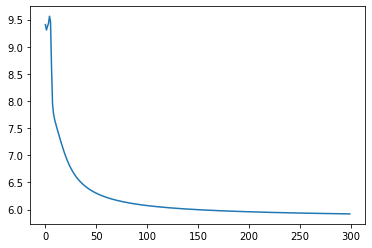

In [306]:
plt.plot(CE_total_list)
plt.show()